Evacuation Planning for West Virigina network

In [1]:
import networkx as nx
from random import sample
import matplotlib.pyplot as plt
import heapq as hq


# Create a graph representing the transportation network
G = nx.Graph()

# Assuming you have the edge data in a text file "edge_data.txt" as mentioned earlier
with open("WV.txt", "r") as file:
    for line in file:
        source, target, weight = map(float, line.strip().split())
        G.add_edge(source, target, weight=weight)


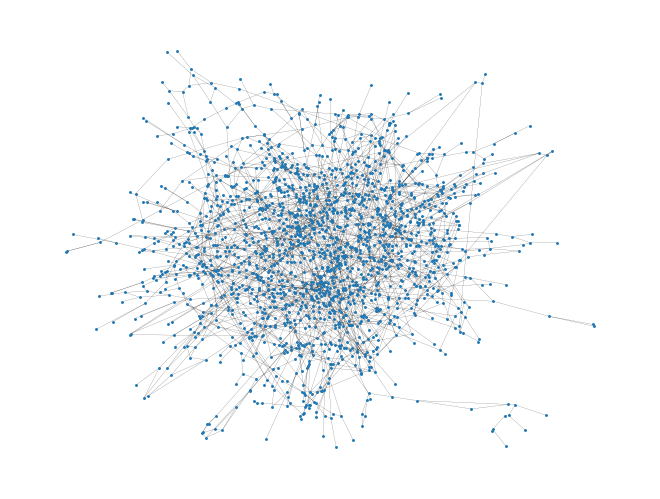

In [2]:
pos = nx.fruchterman_reingold_layout(G)
nx.draw(G,pos,with_labels=False, node_size=1.2, width=0.1)

In [3]:
## As a quick check, let's get the number of nodes and number of edges. The graph is pretty big (expectedly)!
#print(G.number_of_nodes(), G.number_of_edges())

In [4]:
T=nx.minimum_spanning_tree(G) # getting the minimum cost spanning tree

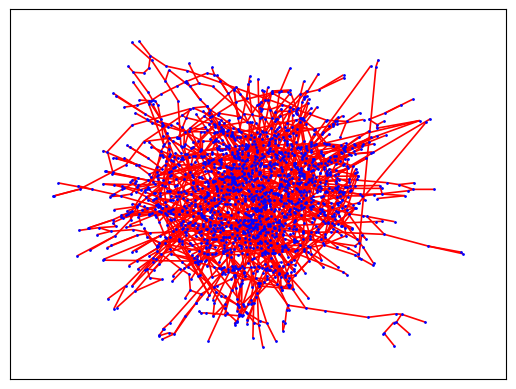

In [5]:
## Plotting only the tree
ered=[(i,j) for (i,j) in T.edges()] # selecting the edges in the tree (so that we can edit or show them in the plot)
nx.draw_networkx_nodes(G,pos,nodelist=G.nodes(), node_color='b', node_size=1)
nx.draw_networkx_edges(G,pos,edgelist=ered, edge_color='r', width=1.2)

In [6]:
shelter = sample(list(G.nodes()), k=1)[0]
#print(shelter)

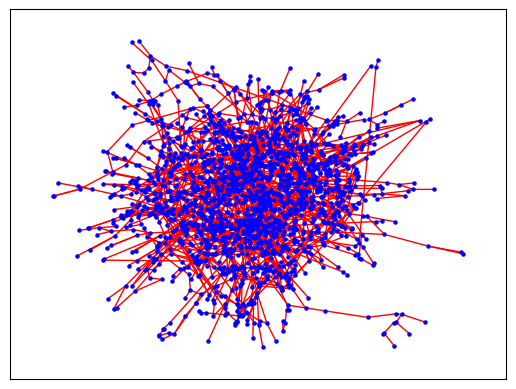

In [7]:
## Plotting all the edges (in red, the edges in the tree)
ered=[(i,j) for (i,j) in T.edges()] # selecting the edges in the tree
nx.draw_networkx_edges(G,pos,edgelist=G.edges(), edge_color='k', width=0.001) # showing all edges (in thinner lines)
nx.draw_networkx_nodes(G,pos,nodelist=G.nodes(), node_color='b', node_size=5)
nx.draw_networkx_edges(G,pos,edgelist=ered, edge_color='r', width=1) # showing the tree edges (in red, and thicker lines)
#fname="spanning_output.png"
#plt.savefig(fname, dpi=300)

In [8]:
# Calculate the time it takes for each node to reach the important locations
Spanning_time_to_shelter = {}
Spanning_time_to_shelter = nx.single_source_dijkstra_path_length(T, shelter, weight='weight')

# Print the time it takes for each node to get to the important locations
print(f"Shelter location is {shelter}:")
for key, value in Spanning_time_to_shelter.items():
    print(f"Time taken for Spanning tree node {key} to reach shelter ({shelter}) is {value}")

Shelter location is 155221720.0:
Time taken for Spanning tree node 155221720.0 to reach shelter (155221720.0) is 0
Time taken for Spanning tree node 155221716.0 to reach shelter (155221720.0) is 19.0
Time taken for Spanning tree node 984966408.0 to reach shelter (155221720.0) is 2471.0
Time taken for Spanning tree node 984966436.0 to reach shelter (155221720.0) is 2516.0
Time taken for Spanning tree node 984966404.0 to reach shelter (155221720.0) is 2568.0
Time taken for Spanning tree node 155187790.0 to reach shelter (155221720.0) is 2615.0
Time taken for Spanning tree node 704210249.0 to reach shelter (155221720.0) is 4166.0
Time taken for Spanning tree node 704210197.0 to reach shelter (155221720.0) is 4177.0
Time taken for Spanning tree node 704210171.0 to reach shelter (155221720.0) is 4190.0
Time taken for Spanning tree node 704210170.0 to reach shelter (155221720.0) is 4202.0
Time taken for Spanning tree node 704210139.0 to reach shelter (155221720.0) is 4336.0
Time taken for Sp

In [9]:
# To get the average time taken for every node to reach the shelter
Spanning_total_time = sum(value for key, value in Spanning_time_to_shelter.items())
Spanning_num_nodes = len(Spanning_time_to_shelter)
Spanning_avg_time = Spanning_total_time/Spanning_num_nodes 

print(f"Average time taken for all Spanning tree nodes to reach shelter node ({shelter}) is {Spanning_avg_time:4f}")

Average time taken for all Spanning tree nodes to reach shelter node (155221720.0) is 206445.515823


In [10]:
print(f"Number of nodes in original graph is {len(G.nodes())}")
print(f"Number of nodes in Min spanning tree is {len(T.nodes())}")
print("Thus, we can say,")
print(f"Avg time taken for all spanning tree nodes to reach shelter = Avg time taken for all nodes to reach shelter = {Spanning_avg_time:4f}")

Number of nodes in original graph is 1896
Number of nodes in Min spanning tree is 1896
Thus, we can say,
Avg time taken for all spanning tree nodes to reach shelter = Avg time taken for all nodes to reach shelter = 206445.515823


In [11]:
def Steiner(G, terminal_nodes):
    tree=nx.Graph()
    
    ### First, check for extreme "cases:
    ### 1. if there are no terminal nodes to connect, then return the empty graph.
    ### 2. If there is only one terminal node, then return a singleton node.
    ### In any other case, we go to the else statement!
    if len(terminal_nodes)==0:
        return tree
    elif len(terminal_nodes)==1:
        tree.add_node(terminal_nodes[0])
        return tree
    else:
        # Create a heap
        myHeap = []
        myPaths = {}
        for i in range(len(terminal_nodes) - 1):
            ### The next few lines print a statement -- useful to monitor progress in large networks.
            a=float(i)/float(len(terminal_nodes)-1)*100
            print("%.1f" % a+"% completed")
            n1 = terminal_nodes[i]
            for n2  in terminal_nodes[i+1:]: 
                # For each pair of nodes, we calculate the shortest path between the two.
                path = nx.bidirectional_dijkstra(G, n1, n2) # path is a tuple: the first element is the distance, the second the nodes it contains
                if path == False: # if the path is not there, something is wrong!
                    terminal_nodes.remove(n2) # To solve the issue, remove the second node, print an error message, and continue
                    continue # THIS SHOULD NEVER HAPPEN! It is simply here to catch a problem with the setup.
                nodelist=path[1]
                distance=path[0]
                # Get the pair we are considering
                pair=[n1,n2]
                # Sort it (so that all terminals are from lower to higher value)
                pair.sort()
                # And push the shortest path and its distance in the heap
                myPaths["%s%s", pair[0], pair[1]]=nodelist
                hq.heappush(myHeap, (distance, pair))
        # When we have all the shortest paths, check the heap and start taking them out, cheapest one first.
        while myHeap:
            myItem=hq.heappop(myHeap)
            # This appears convoluted, but it essentially states that we will add edges to the network, 
            # if i) it is not already there, and ii) it does not form a cycle. 
            if myItem[1][0] not in tree or myItem[1][1] not in tree or not nx.has_path(tree, myItem[1][0], myItem[1][1]):
                tree.add_edge(myItem[1][0], myItem[1][1], weight=myItem[0])
        subgraph=nx.Graph()
        # For all the tree edges, add them in a new subgraph
        for e in tree.edges(data=True):
            pair = [e[0],e[1]]
            pair.sort()
            newList = myPaths["%s%s", pair[0], pair[1]]
            for i in range(len(newList) - 1):
                subgraph.add_edge(newList[i], newList[i+1])
                
        # Return the subgraph's minimum spanning tree
        subgraph = nx.minimum_spanning_tree(subgraph)
        return subgraph

In [12]:
G2=G

In [13]:
# Create a graph representing the transportation network
# G = nx.Graph()

# # Assuming you have the edge data in a text file "edge_data.txt" as mentioned earlier
# with open("WV.txt", "r") as file:
#     for line in file:
#         source, target, weight = map(float, line.strip().split())
#         G.add_edge(source, target, weight=weight)


In [14]:
# pos = nx.fruchterman_reingold_layout(G2)
# nx.draw(G2,pos,with_labels=False, node_size=1.2, width=0.1)

In [15]:
# print(G2.number_of_nodes(), G2.number_of_edges())

In [16]:
big_cities = []
with open("WV_big_cities.txt", "r") as cities_file:
    for line in cities_file:
        big_cities.append(int(line.strip()))

In [17]:
list(big_cities)

[155397660,
 154777788,
 155648784,
 3035898119,
 155480783,
 619628423,
 155480783,
 155504871,
 2199987587,
 155226650]

In [18]:
# print("Shelter is: ",shelter)
terminal_nodes = list(big_cities)
if shelter not in big_cities:
    print("Selected shelter node not in Important cities list. Hence append it to the list")
    terminal_nodes.append(shelter)
Steiner_tree=Steiner(G2,terminal_nodes)

Selected shelter node not in Important cities list. Hence append it to the list
0.0% completed
10.0% completed
20.0% completed
30.0% completed
40.0% completed
50.0% completed
60.0% completed
70.0% completed
80.0% completed
90.0% completed


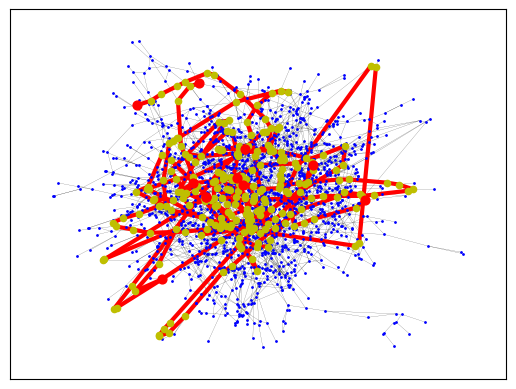

In [19]:
nx.draw_networkx_edges(G2,pos,edgelist=G2.edges(), edge_color='k', width=0.1)
nx.draw_networkx_edges(G2,pos,edgelist=Steiner_tree.edges(), edge_color='r', width=3)
nx.draw_networkx_nodes(G2,pos,nodelist=G2.nodes(), node_color='b', node_size=1)
nx.draw_networkx_nodes(G2,pos,nodelist=Steiner_tree.nodes(), node_color='y',node_size=20)
nx.draw_networkx_nodes(G2,pos,nodelist=terminal_nodes, node_color='r',node_size=40)

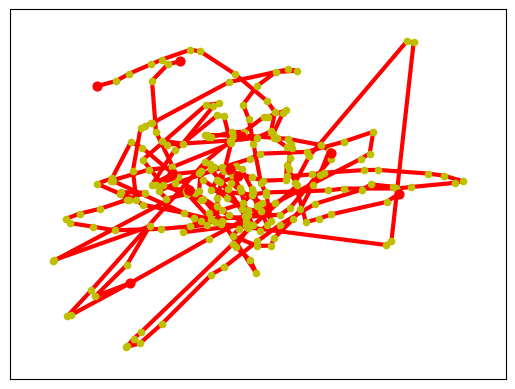

In [20]:
#nx.draw_networkx_edges(G2,pos,edgelist=G.edges(), edge_color='k', width=0.1)
nx.draw_networkx_edges(G2,pos,edgelist=Steiner_tree.edges(), edge_color='r', width=3)
#nx.draw_networkx_nodes(G2,pos,nodelist=G.nodes(), node_color='b', node_size=1)
nx.draw_networkx_nodes(G2,pos,nodelist=Steiner_tree.nodes(), node_color='y',node_size=20)
nx.draw_networkx_nodes(G2,pos,nodelist=terminal_nodes, node_color='r',node_size=40)

In [21]:
 len(Steiner_tree.nodes())

245

In [22]:
# Calculate the time it takes for each node to reach the important locations
Steiner_time_to_shelter = {}
for cities in big_cities:
    Steiner_time_to_shelter[cities] = nx.shortest_path_length(Steiner_tree, source=cities, target=shelter, weight='weight')

for key, value in Steiner_time_to_shelter.items():
    print(f"Time taken for big city {key} in Steiner tree to reach shelter is {value}")

Time taken for big city 155397660 in Steiner tree to reach shelter is 95
Time taken for big city 154777788 in Steiner tree to reach shelter is 135
Time taken for big city 155648784 in Steiner tree to reach shelter is 29
Time taken for big city 3035898119 in Steiner tree to reach shelter is 40
Time taken for big city 155480783 in Steiner tree to reach shelter is 27
Time taken for big city 619628423 in Steiner tree to reach shelter is 53
Time taken for big city 155504871 in Steiner tree to reach shelter is 19
Time taken for big city 2199987587 in Steiner tree to reach shelter is 144
Time taken for big city 155226650 in Steiner tree to reach shelter is 22


In [23]:
# To get the average time taken for every node to reach the shelter
Steiner_total_time = sum(value for key, value in Steiner_time_to_shelter.items())
Steiner_num_nodes = len(Steiner_time_to_shelter)
Steiner_avg_time = Steiner_total_time/Steiner_num_nodes 

print(f"Average time taken for all big cities in Steiner tree to reach shelter node ({shelter}) is {Steiner_avg_time:4f}")

Average time taken for all big cities in Steiner tree to reach shelter node (155221720.0) is 62.666667


In [24]:
print("Summary")
print(f"Average time taken for all spanning tree nodes to reach shelter node ({shelter}) is {Spanning_avg_time:4f}")
print(f"Average time taken for all steiner tree nodes (big cities) to reach shelter node ({shelter}) is {Steiner_avg_time:4f}")

Summary
Average time taken for all spanning tree nodes to reach shelter node (155221720.0) is 206445.515823
Average time taken for all steiner tree nodes (big cities) to reach shelter node (155221720.0) is 62.666667


In [25]:
other_nodes = Steiner_tree.nodes() - terminal_nodes

In [26]:
len(other_nodes)

235

In [27]:
Steiner_other_nodes_time_to_shelter = {}
for nodes in other_nodes:
    Steiner_other_nodes_time_to_shelter[nodes] = nx.shortest_path_length(Steiner_tree, source=nodes, target=shelter, weight='weight')
    
for key, value in Steiner_other_nodes_time_to_shelter.items():
    print(f"Time taken for other Steiner tree node (non-big cities) {key} to reach shelter is {value}")

Time taken for other Steiner tree node (non-big cities) 703644672.0 to reach shelter is 14
Time taken for other Steiner tree node (non-big cities) 984962049.0 to reach shelter is 2
Time taken for other Steiner tree node (non-big cities) 946332676.0 to reach shelter is 98
Time taken for other Steiner tree node (non-big cities) 1127696901.0 to reach shelter is 47
Time taken for other Steiner tree node (non-big cities) 1124601866.0 to reach shelter is 42
Time taken for other Steiner tree node (non-big cities) 9418750998.0 to reach shelter is 108
Time taken for other Steiner tree node (non-big cities) 156241431.0 to reach shelter is 35
Time taken for other Steiner tree node (non-big cities) 984962074.0 to reach shelter is 1
Time taken for other Steiner tree node (non-big cities) 1839818779.0 to reach shelter is 139
Time taken for other Steiner tree node (non-big cities) 2690715167.0 to reach shelter is 17
Time taken for other Steiner tree node (non-big cities) 2690715168.0 to reach shelter

In [28]:
# To get the average time taken for every non-big city node to reach the shelter
Steiner_non_big_total_time = sum(value for key, value in Steiner_other_nodes_time_to_shelter.items())
Steiner_non_big_num_nodes = len(Steiner_other_nodes_time_to_shelter)
Steiner_non_big_avg_time = Steiner_non_big_total_time/Steiner_non_big_num_nodes 

print(f"Average time taken for all non-big cities in Steiner tree to reach shelter node ({shelter}) is {Steiner_non_big_avg_time:4f}")

Average time taken for all non-big cities in Steiner tree to reach shelter node (155221720.0) is 69.429787


In [29]:
remaining_nodes = G.nodes() - Steiner_tree.nodes()

In [30]:
#len(remaining_nodes)

In [31]:
nearest_nodes = {}
for node in remaining_nodes:
    nearest_node = min(Steiner_tree.nodes(), key=lambda n: nx.shortest_path_length(G, source=n, target=node))
    nearest_nodes[node] = nearest_node

In [32]:
#len(nearest_nodes)

The following code block ran for more than 10 mins on the following hardware specifications: <br>

Windows 11 , 64-bit <br>
Intel(R) Core(TM) i5-1035G1 CPU @ 1.00 GHz (8 CPUs), ~1.2 GHz <br>
8192 MB RAM <br>
NVIDIA GeForce MX250 (5969 MB) <br>

In [33]:
# Create a dictionary to store the total time taken for each non-Steiner node
total_time_to_shelter = {}

# Iterate through each non-Steiner node
for node in remaining_nodes:
    # Find the nearest Steiner node using the Steiner tree
    nearest_node = min(Steiner_tree.nodes(), key=lambda n: nx.shortest_path_length(G, source=n, target=node))
    
    # Calculate the time to reach the nearest Steiner node
    time_to_nearest_steiner_node = nx.shortest_path_length(G, source=node, target=nearest_node, weight='weight')
    
    # Calculate the time to reach the shelter from the nearest Steiner node
    time_to_shelter_from_nearest_node = nx.shortest_path_length(Steiner_tree, source=nearest_node, target=shelter, weight='weight')
    
    # Total time is the sum of the two times
    total_time = time_to_nearest_steiner_node + time_to_shelter_from_nearest_node
    
    # Store the total time in the dictionary
    total_time_to_shelter[node] = total_time

# Now, the `total_time_to_shelter` dictionary contains the total time it takes for each non-Steiner node to reach the shelter through the Steiner tree.


In [34]:
for node, time in total_time_to_shelter.items():
    print(f"Time taken for non-steiner tree node {node} to reach shelter is {time}")

Time taken for non-steiner tree node 364101633.0 to reach shelter is 5233.0
Time taken for non-steiner tree node 2405613569.0 to reach shelter is 8448.0
Time taken for non-steiner tree node 2876162052.0 to reach shelter is 3683.0
Time taken for non-steiner tree node 155279369.0 to reach shelter is 3478.0
Time taken for non-steiner tree node 155312139.0 to reach shelter is 65747.0
Time taken for non-steiner tree node 866050072.0 to reach shelter is 3472.0
Time taken for non-steiner tree node 155033631.0 to reach shelter is 288764.0
Time taken for non-steiner tree node 3770654763.0 to reach shelter is 782.0
Time taken for non-steiner tree node 156147757.0 to reach shelter is 53162.0
Time taken for non-steiner tree node 656916535.0 to reach shelter is 1983.0
Time taken for non-steiner tree node 656916536.0 to reach shelter is 667.0
Time taken for non-steiner tree node 945987641.0 to reach shelter is 989.0
Time taken for non-steiner tree node 656916544.0 to reach shelter is 821.0
Time take

In [35]:
# To get the average time taken for non steiner node to reach the shelter
non_Steiner_total_time = sum(value for key, value in total_time_to_shelter.items())
non_Steiner_num_nodes = len(total_time_to_shelter)
non_Steiner_avg_time = non_Steiner_total_time/non_Steiner_num_nodes 

print(f"Average time taken for all non-Steiner tree nodes to reach shelter node ({shelter}) is {non_Steiner_avg_time:4f}")

Average time taken for all non-Steiner tree nodes to reach shelter node (155221720.0) is 23180.471230


In [36]:
#len(total_time_to_shelter)

### Summary

In [37]:
print(f"1. Average time taken for all spanning tree nodes to reach shelter is {Spanning_avg_time}")
print(f"2. Average time taken for all big city nodes in Steiner tree to reach shelter is {Steiner_avg_time}")
print(f"3. Average time taken for all non-big city nodes in Steiner tree to reach shelter is {Steiner_non_big_avg_time}")
print(f"4. Average time taken for non-Steiner tree nodes to reach shelter (via Steiner tree) is {non_Steiner_avg_time}")

Average time taken for all spanning tree nodes to reach shelter is 206445.5158227848
Average time taken for all big city nodes in Steiner tree to reach shelter is 62.666666666666664
Average time taken for all non-big city nodes in Steiner tree to reach shelter is 69.42978723404255
Average time taken for non-Steiner tree nodes to reach shelter (via Steiner tree) is 23180.471229557843


Observation is as follows: 
1. Avg time taken for all big cities to reach shelter < Avg time taken for all nodes (when considered equally important) to reach shelter i.e Statement 2 < Statement 1 
2. Let us assume that the big cities in West Virgina contribute to 80% of its total population. Hence we can say that, by concentrating on the big cities' evacuation to shelter first, we can move 80% of total WV population in a time given by Statement 2.
3. If we concentrate on moving all the people in all cities to shelter all at once, it would take a time of Statement 1. Which is much much much higher than while considering to evacuate 80% of the population.
4. Thus, in emergency situations, considering the big cities to evacuate first would save most of the population while still giving some time to save the rest of the population too.